# IDENTIFICAÇÃO DE FOGO EM IMAGENS UTILIZANDO TÉCNICAS DE CLASSIFICAÇÃO

Um problema de visão computacional que utiliza uma abordagem de aprendizado supervisionada para classificar imagens de acordo com a presença e ausência de fogo.

- **Descrição da base de dados:** A base de dados possui imagens com e sem fogo ao ar livre para tarefas de visão computacional. Ao todo são 999 imagens, onde 755 são de fogo ao ar livre podendo apresentar fumaça densa, e 244 não são de fogo e podem apresentar grama, estradas, árvores, florestas, lagos, rios, cachoeiras, animais e pessoas. 


- **Link da base de dados original:** https://www.kaggle.com/datasets/phylake1337/fire-dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
PREFIX_PATH='/content/'

RESIZE_X = 100
RESIZE_Y = 100
CHANNEL = 3
FLATTEN_SHAPE = RESIZE_X * RESIZE_Y * CHANNEL
COLUMNS_PIXELS = ['pixel{}'.format(i) for i in range(0, FLATTEN_SHAPE)]

COLOR_HIST_RANGE = range(0, 256)
COLUMNS_HIST_B = ['hist_b_{}'.format(i) for i in COLOR_HIST_RANGE]
COLUMNS_HIST_G = ['hist_g_{}'.format(i) for i in COLOR_HIST_RANGE]
COLUMNS_HIST_R = ['hist_r_{}'.format(i) for i in COLOR_HIST_RANGE]
HIST_COLUMNS = COLUMNS_HIST_B + COLUMNS_HIST_G + COLUMNS_HIST_R

TOTAL_PIXELS_COLUMNS = FLATTEN_SHAPE + (256*3)

pixels_hist_columns = COLUMNS_PIXELS+COLUMNS_HIST_B+COLUMNS_HIST_G+COLUMNS_HIST_R
desc_columns = ['image_path', 'label', 'label_name', 'source_shape', 'source_height', 'source_width', 'source_channel']
COLUMNS_FULL_DF = desc_columns + pixels_hist_columns  

NOISES = [
  "gaussian",
  "localvar",
  "poisson",
  "salt",
  "pepper",
  "s&p",
  "speckle",
]

## Importação de bibliotecas

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import cv2
from google.colab.patches import cv2_imshow

import glob
import os

from sklearn.model_selection import train_test_split

import albumentations as A
import skimage
import random

## Praparando diretório para acessar API KEY da API do Kaggle para download da base de dados

Faça o upload do kaggle.json que contém sua API KEY

In [ ]:
! cp '/content/kaggle.json' .

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d phylake1337/fire-dataset

 99% 385M/387M [00:12<00:00, 26.9MB/s]
100% 387M/387M [00:12<00:00, 31.4MB/s]


In [ ]:
! unzip fire-dataset.zip

## Carregamento inicial dos dados

In [ ]:
! cd /content/fire_dataset

In [ ]:
def get_image_attrs(image_path, label_tuple):
  values = []
  values += [image_path, label_tuple[0], label_tuple[1]]  
  image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

  if image is None:
    values += [np.NaN]* (4 + TOTAL_PIXELS_COLUMNS)
    return values

  shape = image.shape
  values += [str(shape), shape[0], shape[1], shape[2]]
  if shape[2] != 3:
    values += [np.NaN]*TOTAL_PIXELS_COLUMNS
    return values
  
  resized_image = cv2.resize(image, (RESIZE_X, RESIZE_Y))
  values += resized_image.flatten().tolist()
  for i in range(0,3):
    hist = cv2.calcHist(resized_image, [i], None, [256], [0, 256])
    values += hist.flatten().tolist()  
  return values


def load_dataset():
  non_fire_paths = glob.glob('fire_dataset/non_fire_images/*.png')
  fire_paths =  glob.glob('fire_dataset/fire_images/*.png')
  data = {(0, 'Sem fogo'): non_fire_paths,(1, 'Com fogo'): fire_paths}

  images_attrs = []
  for label, paths in data.items():
    for path in paths:
      images_attrs.append(get_image_attrs(path, label))

  return pd.DataFrame(images_attrs, columns=COLUMNS_FULL_DF)

df_images_base = load_dataset()
df_images_base.to_csv('{}images_full_dataset.csv'.format(PREFIX_PATH), index=False)
df_images_base.head()

,image_path,label,label_name,source_shape,source_height,source_width,source_channel,pixel0,pixel1,pixel2,...,hist_r_246,hist_r_247,hist_r_248,hist_r_249,hist_r_250,hist_r_251,hist_r_252,hist_r_253,hist_r_254,hist_r_255
0,fire_dataset/non_fire_images/non_fire.151.png,0,Sem fogo,"(335, 733, 3)",335.0,733.0,3.0,170.0,135.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fire_dataset/non_fire_images/non_fire.126.png,0,Sem fogo,"(390, 585, 3)",390.0,585.0,3.0,125.0,158.0,134.0,...,5.0,4.0,4.0,1.0,8.0,10.0,6.0,12.0,10.0,3.0
2,fire_dataset/non_fire_images/non_fire.104.png,0,Sem fogo,"(685, 1024, 3)",685.0,1024.0,3.0,69.0,176.0,176.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,fire_dataset/non_fire_images/non_fire.216.png,0,Sem fogo,"(1349, 1100, 3)",1349.0,1100.0,3.0,61.0,67.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fire_dataset/non_fire_images/non_fire.110.png,0,Sem fogo,"(2592, 3872, 3)",2592.0,3872.0,3.0,74.0,193.0,121.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,17.0


In [ ]:
df_images_base = pd.read_csv('{}images_full_dataset.csv'.format(PREFIX_PATH))

In [ ]:
df_images_base.shape

(999, 30775)

In [ ]:
df_images = df_images_base.copy()
df_eda_images = df_images_base.copy()

In [ ]:
df_images = df_images.loc[df_images['source_channel']==3].reset_index(drop=True)
df_images.shape

(992, 30775)

In [ ]:
# df_images.to_csv('{}images_dataset.csv'.format(PREFIX_PATH), index=False)
df_images = pd.read_csv('{}images_dataset.csv'.format(PREFIX_PATH))

In [ ]:
df_images.shape

(992, 30775)

## EDA do shape da imagem e do balanceamento dos dados

In [ ]:
df_eda_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 30775 entries, image_path to hist_r_255
dtypes: float64(30771), int64(1), object(3)
memory usage: 234.6+ MB


In [ ]:
df_eda_images['source_channel'].describe()

count    998.000000
mean       3.006012
std        0.077343
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: source_channel, dtype: float64

In [ ]:
fig = px.pie(df_eda_images, values='source_channel', names='source_channel',  title='Share de canais de cores na base de imagens', labels={'source_channel': 'canal de cores'})
fig.update_traces(textinfo='percent+label')
fig.show()

In [ ]:
df_eda_images = df_eda_images.loc[df_eda_images['source_channel']==3].reset_index(drop=True)
df_eda_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Columns: 30775 entries, image_path to hist_r_255
dtypes: float64(30771), int64(1), object(3)
memory usage: 232.9+ MB


In [ ]:
#@title Proporção dos dados em relação à classe
df_categories_proportion = df_eda_images.groupby('label_name').count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion['percent_by_label'] = round(df_categories_proportion['total_by_label']/df_categories_proportion['total_by_label'].sum() *100, 2)

display(df_categories_proportion)

fig = go.Figure([go.Bar(
    y=df_categories_proportion['label_name'], 
    x=df_categories_proportion['percent_by_label'],
    text=df_categories_proportion['percent_by_label'],
    textposition='auto',
    texttemplate="%{text}%",
    orientation='h',
)])
fig.update_xaxes(showticklabels=False)

fig.update_layout(
    title='Proporção dos dados em relação à classe',
    # paper_bgcolor='#fff',
    plot_bgcolor='#fff',

)
fig.show()

,label_name,total_by_label,label,source_shape,source_height,source_width,source_channel,pixel0,pixel1,pixel2,...,hist_r_247,hist_r_248,hist_r_249,hist_r_250,hist_r_251,hist_r_252,hist_r_253,hist_r_254,hist_r_255,percent_by_label
0,Com fogo,752,752,752,752,752,752,752,752,752,...,752,752,752,752,752,752,752,752,752,75.81
1,Sem fogo,240,240,240,240,240,240,240,240,240,...,240,240,240,240,240,240,240,240,240,24.19


In [ ]:
print('Quantidade de dimensões diferentes na base: ', len(df_eda_images['source_shape'].unique()))

Quantidade de dimensões diferentes na base:  599


In [ ]:
df_image_shapes = df_eda_images.groupby(['source_height', 'source_width', 'label_name']).size().reset_index().rename(columns={0:'count'})
df_image_shapes

,source_height,source_width,label_name,count
0,147.0,220.0,Com fogo,1
1,165.0,220.0,Sem fogo,2
2,165.0,293.0,Com fogo,2
3,172.0,292.0,Com fogo,1
4,173.0,307.0,Com fogo,1
...,...,...,...,...
639,3840.0,5760.0,Com fogo,1
640,3840.0,5760.0,Sem fogo,1
641,3864.0,5152.0,Com fogo,1
642,4480.0,6720.0,Com fogo,1


In [ ]:
df_image_shapes.describe()

,source_height,source_width,count
count,644.000000,644.000000,644.000000
mean,801.419255,1227.131988,1.540373
std,734.941881,1075.517365,1.720768
min,147.000000,185.000000,1.000000
25%,394.750000,640.000000,1.000000
50%,550.000000,881.500000,1.000000
75%,807.750000,1280.000000,1.000000
max,4608.000000,6720.000000,20.000000


In [ ]:
fig = px.scatter(df_eda_images, x="source_height", y="source_width", facet_col="label_name")
fig.update_xaxes(title_text='Largura')
fig.update_yaxes(title_text='Altura')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(
    title='Tamanho das imagens (pixels)',
    # plot_bgcolor='#fff',

)
fig.show()

In [ ]:
fig = px.scatter(df_image_shapes, x="source_height", y="source_width", facet_col="label_name", size='count', color='count')
fig.update_xaxes(title_text='Largura')
fig.update_yaxes(title_text='Altura')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(
    title='Tamanho das imagens (pixels)',
    # plot_bgcolor='#fff',

)
fig.show()

In [ ]:
df_image_shapes_0 = df_eda_images.loc[df_eda_images['label']==0]
df_image_shapes_1 = df_eda_images.loc[df_eda_images['label']==1]
altura0 = ['Altura'] * len(df_image_shapes_0)
altura1 = ['Altura'] * len(df_image_shapes_1)

largura0 = ['Largura'] * len(df_image_shapes_0)
largura1 = ['Largura'] * len(df_image_shapes_1)
fig = go.Figure()
fig.add_trace(go.Box(y=df_image_shapes_0['source_height'], x=altura0, name='Sem fogo', marker_color='blue'))
fig.add_trace(go.Box(y=df_image_shapes_1['source_height'], x=altura1, name='Com fogo', marker_color='red'))

fig.add_trace(go.Box(y=df_image_shapes_0['source_width'], x=largura0, name='Sem fogo', marker_color='blue'))
fig.add_trace(go.Box(y=df_image_shapes_1['source_width'], x=largura1, name='Com fogo', marker_color='red'))
fig.update_layout(
    title='Tamanho das imagens (pixels)',
    yaxis_title='Quantidade de pixels',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.show()

## Amostragem dos dados

In [ ]:
df_sample = pd.read_csv('{}sample.csv'.format(PREFIX_PATH))
df_sample.head()

,index,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,label
0,33,4.0,63.0,15.0,81.0,134.0,91.0,3.0,9.0,4.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0
1,100,0.0,174.0,66.0,36.0,158.0,90.0,125.0,250.0,224.0,...,10.0,85.0,53.0,4.0,66.0,19.0,0.0,29.0,1.0,0
2,106,239.0,255.0,254.0,239.0,255.0,254.0,239.0,255.0,254.0,...,17.0,40.0,23.0,9.0,13.0,8.0,13.0,22.0,12.0,0
3,117,48.0,50.0,41.0,66.0,64.0,52.0,47.0,43.0,28.0,...,1.0,5.0,36.0,0.0,0.0,8.0,0.0,0.0,0.0,0
4,115,250.0,255.0,255.0,243.0,254.0,255.0,247.0,255.0,255.0,...,126.0,156.0,148.0,29.0,63.0,59.0,17.0,40.0,30.0,0


In [ ]:
# df_sample = df_images[COLUMNS_PIXELS + ['label']].groupby('label').sample(n=5).copy().reset_index()
# df_sample.to_csv('{}sample.csv'.format(PREFIX_PATH), index=False)
# df_sample.head()

,index,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,label
0,33,4.0,63.0,15.0,81.0,134.0,91.0,3.0,9.0,4.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0
1,100,0.0,174.0,66.0,36.0,158.0,90.0,125.0,250.0,224.0,...,10.0,85.0,53.0,4.0,66.0,19.0,0.0,29.0,1.0,0
2,106,239.0,255.0,254.0,239.0,255.0,254.0,239.0,255.0,254.0,...,17.0,40.0,23.0,9.0,13.0,8.0,13.0,22.0,12.0,0
3,117,48.0,50.0,41.0,66.0,64.0,52.0,47.0,43.0,28.0,...,1.0,5.0,36.0,0.0,0.0,8.0,0.0,0.0,0.0,0
4,115,250.0,255.0,255.0,243.0,254.0,255.0,247.0,255.0,255.0,...,126.0,156.0,148.0,29.0,63.0,59.0,17.0,40.0,30.0,0


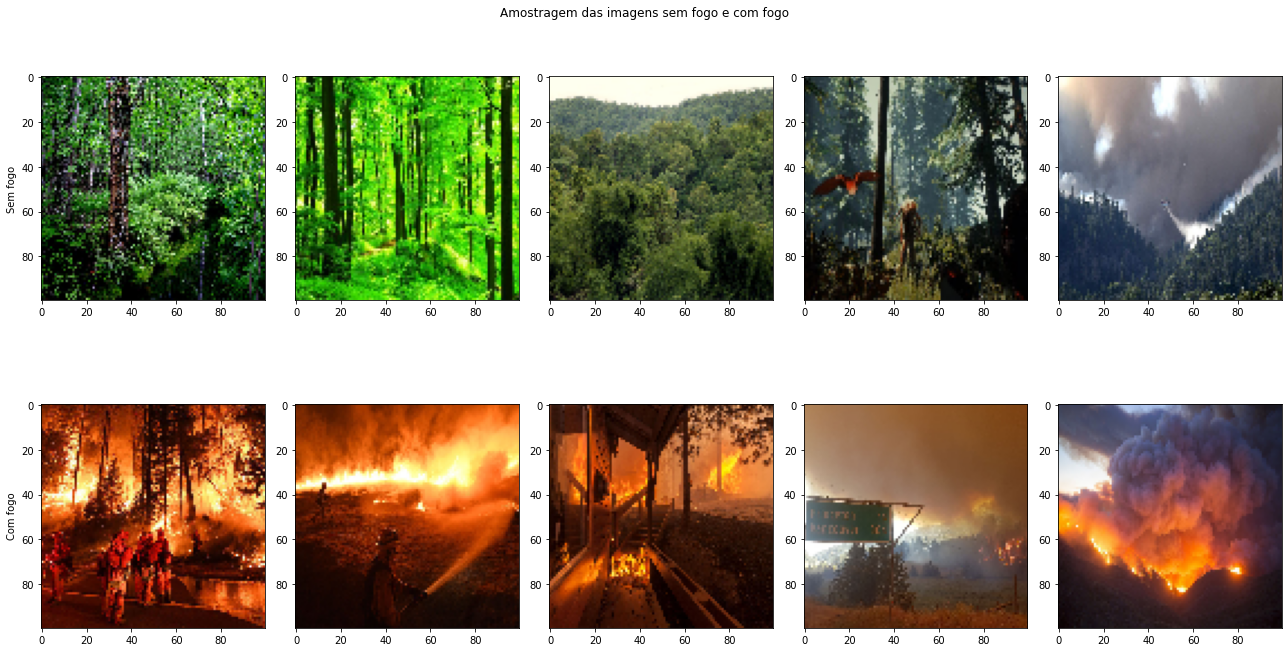

In [ ]:
figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(18, 10))
for i in range(0,10):
  image_flatten = df_sample.loc[i][COLUMNS_PIXELS].to_numpy(dtype='uint8')
  resized_image = image_flatten.reshape(RESIZE_X, RESIZE_Y, CHANNEL)
  image = resized_image
  ax.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.suptitle('Amostragem das imagens sem fogo e com fogo')
plt.setp(ax[0, 0], ylabel='Sem fogo')
plt.setp(ax[1, 0], ylabel='Com fogo')
plt.tight_layout()
plt.show()

## Histogramas

In [ ]:
def get_df_eda(df, label):
  df_aux = pd.DataFrame(df.loc[df['label']==label][HIST_COLUMNS]).reset_index(drop=True)
  df_describe = df_aux.describe()
  return df_describe

In [ ]:
df_eda_0 = get_df_eda(df_images, 0)
df_eda_1 = get_df_eda(df_images, 1)

In [ ]:
def plot_single_histogram_bgr(b, g, r, title):
  fig = plt.figure(figsize=(9, 5))
  plt.plot(b, color='b')
  plt.plot(g, color='g')
  plt.plot(r, color='r')
  plt.xlim([0,256])
  plt.title(title)
  plt.show()


def plot_histogram(df_0, df_1, field, title, title_0, title_1):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

  ax1.plot(df_0[COLUMNS_HIST_B].loc[field].to_list(), color='b')
  ax1.plot(df_0[COLUMNS_HIST_G].loc[field].to_list(), color='g')
  ax1.plot(df_0[COLUMNS_HIST_R].loc[field].to_list(), color='r')
  
  ax2.plot(df_1[COLUMNS_HIST_B].loc[field].to_list(), color='b')
  ax2.plot(df_1[COLUMNS_HIST_G].loc[field].to_list(), color='g')
  ax2.plot(df_1[COLUMNS_HIST_R].loc[field].to_list(), color='r')
  
  plt.xlim([0,256])
  ax1.set_title(title_0)
  ax2.set_title(title_1)
  plt.suptitle(title)
  plt.show()

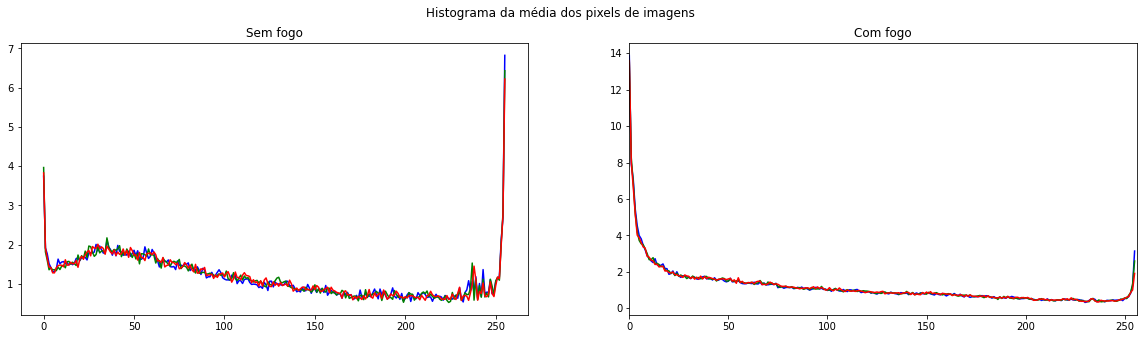

In [ ]:
plot_histogram(
    df_eda_0, 
    df_eda_1, 
    'mean', 
    'Histograma da média dos pixels de imagens',
    'Sem fogo',  
    'Com fogo'
)

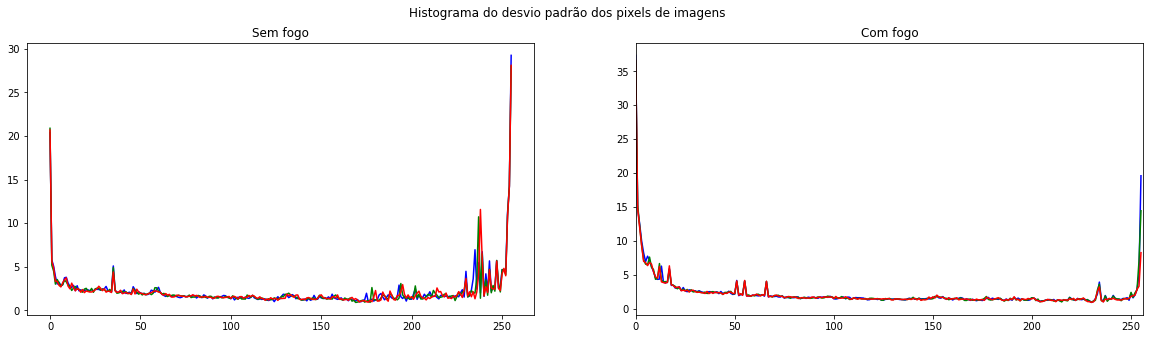

In [ ]:
plot_histogram(
    df_eda_0, 
    df_eda_1, 
    'std', 
    'Histograma do desvio padrão dos pixels de imagens',
    'Sem fogo',  
    'Com fogo'
)

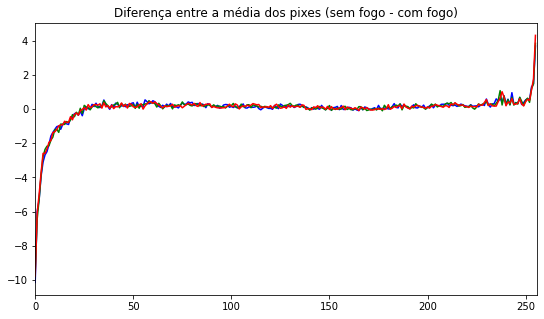

In [ ]:
b = (df_eda_0[COLUMNS_HIST_B].loc['mean'] - df_eda_1[COLUMNS_HIST_B].loc['mean']).to_list()
g = (df_eda_0[COLUMNS_HIST_G].loc['mean'] - df_eda_1[COLUMNS_HIST_G].loc['mean']).to_list()
r = (df_eda_0[COLUMNS_HIST_R].loc['mean'] - df_eda_1[COLUMNS_HIST_R].loc['mean']).to_list()

plot_single_histogram_bgr(b, g, r, 'Diferença entre a média dos pixes (sem fogo - com fogo)')

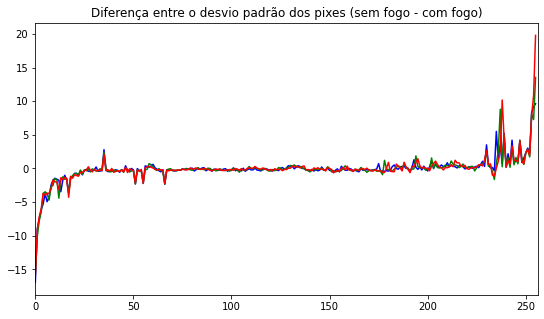

In [ ]:
b = (df_eda_0[COLUMNS_HIST_B].loc['std'] - df_eda_1[COLUMNS_HIST_B].loc['std']).to_list()
g = (df_eda_0[COLUMNS_HIST_G].loc['std'] - df_eda_1[COLUMNS_HIST_G].loc['std']).to_list()
r = (df_eda_0[COLUMNS_HIST_R].loc['std'] - df_eda_1[COLUMNS_HIST_R].loc['std']).to_list()

plot_single_histogram_bgr(b, g, r, 'Diferença entre o desvio padrão dos pixes (sem fogo - com fogo)')

## Retorna conjunto de treinamento, validação e teste

In [4]:
#@title get_df_train_valid_test
def get_df_train_valid_test(prefix_path, df=None, split=False):
  if split:
    df0 = df.loc[df['label']==0].copy()
    df1 = df.loc[df['label']==1].copy()

    n_sample = df1.shape[0] - df0.shape[0]
    df_test_1_aux = df1.sample(n=n_sample).copy()
    df1 = df1.drop(df_test_1_aux.index)

    df_train_0, df_valid_test_0 = train_test_split(df0, test_size=0.30)
    df_train_1, df_valid_test_1 = train_test_split(df1, test_size=0.30)    
    df_valid_0, df_test_0 = train_test_split(df_valid_test_0, test_size=0.30)
    df_valid_1, df_test_1 = train_test_split(df_valid_test_1, test_size=0.30)

    df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)
    df_valid = pd.concat([df_valid_0, df_valid_1], ignore_index=True)
    df_test = pd.concat([df_test_0, df_test_1, df_test_1_aux], ignore_index=True)
    
    df_train.to_csv('{}train_images.csv'.format(prefix_path), index=False)
    df_valid.to_csv('{}valid_images.csv'.format(prefix_path), index=False)
    df_test.to_csv('{}test_images.csv'.format(prefix_path), index=False)
  else:
    df_train = pd.read_csv('{}train_images.csv'.format(prefix_path))
    df_valid = pd.read_csv('{}valid_images.csv'.format(prefix_path))
    df_test = pd.read_csv('{}test_images.csv'.format(prefix_path))

  return df_train, df_valid, df_test

# df_train, df_valid, df_test = get_df_train_valid_test(prefix_path=PREFIX_PATH, df=df_images, split=True)
df_train, df_valid, df_test = get_df_train_valid_test(prefix_path=PREFIX_PATH)

In [ ]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(336, 30775)
(100, 30775)
(556, 30775)


In [ ]:
#@title Proporção dos dados em relação à classe por conjunto de dados
df_categories_proportion_train = df_train.groupby('label')['image_path'].count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion_train['percent_by_label'] = round(df_categories_proportion_train['total_by_label']/df_categories_proportion_train['total_by_label'].sum() *100, 2)
display(df_categories_proportion_train)

df_categories_proportion_valid = df_valid.groupby('label')['image_path'].count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion_valid['percent_by_label'] = round(df_categories_proportion_valid['total_by_label']/df_categories_proportion_valid['total_by_label'].sum() *100, 2)
display(df_categories_proportion_valid)


df_categories_proportion_test = df_test.groupby('label')['image_path'].count().reset_index().rename(columns={'image_path':'total_by_label'})
df_categories_proportion_test['percent_by_label'] = round(df_categories_proportion_test['total_by_label']/df_categories_proportion_test['total_by_label'].sum() *100, 2)
display(df_categories_proportion_test)

,label,total_by_label,percent_by_label
0,0,168,50.0
1,1,168,50.0


,label,total_by_label,percent_by_label
0,0,50,50.0
1,1,50,50.0


,label,total_by_label,percent_by_label
0,0,22,3.96
1,1,534,96.04


## Data albumentation e adição de ruído

In [5]:
main_columns = ['image_path', 'label', 'label_name']
columns = main_columns + COLUMNS_PIXELS
df_train_aux = df_train[columns].copy()
df_train_aux['pre_process_type'] = 'Original'
df_train_aux.head(2)

,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
0,fire_dataset/non_fire_images/non_fire.27.png,0,Não fogo,70.0,74.0,72.0,50.0,55.0,59.0,32.0,...,9.0,51.0,37.0,9.0,51.0,39.0,17.0,28.0,27.0,Original
1,fire_dataset/non_fire_images/non_fire.125.png,0,Não fogo,254.0,254.0,254.0,254.0,254.0,254.0,254.0,...,66.0,94.0,84.0,18.0,22.0,14.0,95.0,130.0,111.0,Original


In [6]:
#@title get_one_of_albumentation
def get_one_of_albumentation(image):  
  transform = A.Compose([
    A.OneOf([
      A.RGBShift(),
      A.HueSaturationValue(),
      A.ChannelShuffle(),
      A.CLAHE(),
      A.RandomContrast(),
      A.RandomGamma(),
      A.RandomBrightness(),
      A.Blur(),
      A.MedianBlur(),
      A.ToGray(),
      A.JpegCompression(),
      A.RandomRotate90(),
      A.RandomCrop(width=16, height=16),
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(p=0.5),
      A.Transpose(),
      A.OpticalDistortion(),
      A.GridDistortion(),
      A.Compose([
        A.CLAHE(),
        A.RandomRotate90(),
        A.Transpose(),
        A.ShiftScaleRotate(
            shift_limit=0.0625, 
            scale_limit=0.50, 
            rotate_limit=45, 
            p=.75
        ),
        A.Blur(blur_limit=3),
        A.OpticalDistortion(),
        A.GridDistortion(),
        A.HueSaturationValue(),
      ]),
      A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(
            shift_limit=0.0625, 
            scale_limit=0.2, 
            rotate_limit=45, 
            p=0.2
        ),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
      ])
    ])
  ])

  augmented_image = transform(image=image)['image']
  return augmented_image.flatten().tolist()


def get_one_of_noise(image):
  noise_mode = random.choice(NOISES)
  noised_image = skimage.util.random_noise(image, mode=noise_mode, seed=100)
  return noised_image.flatten().tolist()

In [7]:
#@title get_albumentations_and_noises
def get_albumentations_and_noises(df, main_columns=['image_path', 'label', 'label_name']):
  albumentations = []
  noises = []
  for index, row in df.iterrows():
    image_flatten = row[COLUMNS_PIXELS].to_numpy(dtype='uint8')
    image = image_flatten.reshape(RESIZE_X, RESIZE_Y, CHANNEL)

    augmented_image_pixels = get_one_of_albumentation(image)
    albumentations.append(augmented_image_pixels)

    noised_image_pixels = get_one_of_noise(image)
    noises.append(noised_image_pixels)

  df_albumentations = pd.DataFrame(albumentations, columns=COLUMNS_PIXELS, index=df[main_columns].index)
  df_albumentations['pre_process_type'] = 'Albumentation'
  df_albumentations = pd.concat([df[main_columns], df_albumentations], axis=1)

  df_noises = pd.DataFrame(noises, columns=COLUMNS_PIXELS, index=df[main_columns].index)
  df_noises['pre_process_type'] = 'Noise'
  df_noises = pd.concat([df[main_columns], df_noises], axis=1)

  # df_albumentations_noises = pd.concat([df_albumentations, df_noises], ignore_index=True)
  return df_albumentations, df_noises

In [8]:
# df_albumentations, df_noises = get_albumentations_and_noises(df_train_aux)
# df_albumentations.to_csv('{}train_images_albumentation.csv'.format(PREFIX_PATH), index=False)
# df_noises.to_csv('{}train_images_noise.csv'.format(PREFIX_PATH), index=False)

df_albumentations = pd.read_csv('{}train_images_albumentation.csv'.format(PREFIX_PATH))
df_noises = pd.read_csv('{}train_images_noise.csv'.format(PREFIX_PATH))

In [9]:
df_train_aux1 = pd.concat([df_train_aux, df_albumentations, df_noises], ignore_index=True).sort_values(['label', 'image_path', 'pre_process_type'], ascending = [True, True, False]).reset_index(drop=True)
display(df_train_aux1.head(3))
display(df_train_aux1.tail(3))

,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
0,fire_dataset/non_fire_images/non_fire.1.png,0,Não fogo,200.000000,200.000000,200.000000,201.000000,201.000000,201.000000,200.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Original
1,fire_dataset/non_fire_images/non_fire.1.png,0,Não fogo,0.609337,0.818582,0.899617,0.762992,0.886367,0.839657,0.806432,...,0.052206,0.0,0.083204,0.108284,0.0,0.110259,0.021568,0.0,0.018842,Noise
2,fire_dataset/non_fire_images/non_fire.1.png,0,Não fogo,230.000000,230.000000,230.000000,231.000000,231.000000,231.000000,230.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Albumentation


,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
1005,fire_dataset/fire_images/fire.98.png,1,Fogo,6.0,14.00000,31.000000,6.0,13.000000,32.000000,6.000000,...,16.000000,38.000000,90.000000,19.000000,39.000000,87.000000,18.000000,37.000000,83.000000,Original
1006,fire_dataset/fire_images/fire.98.png,1,Fogo,0.0,0.08917,0.236872,0.0,0.149112,0.176912,0.045647,...,0.114951,0.084443,0.436145,0.182794,0.042846,0.451435,0.092156,0.016576,0.344332,Noise
1007,fire_dataset/fire_images/fire.98.png,1,Fogo,6.0,14.00000,31.000000,6.0,13.000000,32.000000,6.000000,...,16.000000,38.000000,90.000000,19.000000,39.000000,87.000000,18.000000,37.000000,83.000000,Albumentation


In [10]:
albumented_images = ['fire_dataset/non_fire_images/non_fire.235.png', 'fire_dataset/fire_images/fire.136.png', 'fire_dataset/fire_images/fire.106.png', 'fire_dataset/fire_images/fire.109.png', 'fire_dataset/fire_images/fire.120.png', 'ire_dataset/fire_images/fire.121.png', 'ire_dataset/fire_images/fire.122.png'] #,'fire_dataset/fire_images/fire.183.png']
df_albumented_sample = df_train_aux1.loc[df_train_aux1['image_path'].isin(albumented_images)].sort_values(['pre_process_type', 'label'], ascending = [False, True]).reset_index(drop=True)
# df_albumented_sample = df_train_aux.sort_values(['image_path', 'label', 'pre_process_type'], ascending = [True, True, False]).reset_index(drop=True).loc[40:48].reset_index(drop=True)
df_albumented_sample

,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
0,fire_dataset/non_fire_images/non_fire.235.png,0,Não fogo,34.000000,46.000000,39.000000,6.000000,22.000000,5.000000,12.000000,...,3.000000,5.000000,15.000000,4.000000,5.000000,15.000000,8.000000,4.000000,15.000000,Original
1,fire_dataset/fire_images/fire.106.png,1,Fogo,248.000000,250.000000,250.000000,252.000000,255.000000,253.000000,252.000000,...,105.000000,126.000000,127.000000,72.000000,93.000000,91.000000,74.000000,80.000000,77.000000,Original
2,fire_dataset/fire_images/fire.109.png,1,Fogo,125.000000,94.000000,74.000000,110.000000,75.000000,62.000000,107.000000,...,74.000000,64.000000,55.000000,7.000000,9.000000,1.000000,16.000000,15.000000,5.000000,Original
3,fire_dataset/fire_images/fire.120.png,1,Fogo,163.000000,150.000000,142.000000,160.000000,146.000000,127.000000,159.000000,...,63.000000,59.000000,63.000000,86.000000,81.000000,89.000000,55.000000,52.000000,54.000000,Original
4,fire_dataset/fire_images/fire.136.png,1,Fogo,4.000000,7.000000,11.000000,7.000000,8.000000,12.000000,13.000000,...,42.000000,54.000000,66.000000,45.000000,53.000000,70.000000,52.000000,54.000000,72.000000,Original
5,fire_dataset/non_fire_images/non_fire.235.png,0,Não fogo,0.000000,0.214660,0.268245,0.000000,0.184407,0.071030,0.069177,...,0.063971,0.000000,0.142027,0.123971,0.000000,0.169082,0.052941,0.000000,0.077665,Noise
6,fire_dataset/fire_images/fire.106.png,1,Fogo,0.797572,1.000000,1.000000,0.962992,1.000000,1.000000,1.000000,...,0.463971,0.429541,0.581243,0.390637,0.254610,0.467121,0.311764,0.185203,0.320802,Noise
7,fire_dataset/fire_images/fire.109.png,1,Fogo,0.490196,0.368627,0.290196,0.431373,1.000000,0.243137,0.419608,...,0.290196,0.250980,0.215686,0.027451,0.035294,0.003922,0.062745,0.058824,0.019608,Noise
8,fire_dataset/fire_images/fire.120.png,1,Fogo,0.464239,0.622503,0.672166,0.602207,0.670681,0.549461,0.645647,...,0.299265,0.166795,0.330262,0.445539,0.207552,0.459278,0.237254,0.075400,0.230606,Noise
9,fire_dataset/fire_images/fire.136.png,1,Fogo,0.000000,0.061719,0.158441,0.002207,0.129505,0.098481,0.073098,...,0.216912,0.147188,0.342027,0.284755,0.097748,0.384768,0.225490,0.083243,0.301195,Noise


In [11]:
figure, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 15))
for i in range(0,15):
  if df_albumented_sample.loc[i]['pre_process_type'] == 'Noise':
    image_flatten = df_albumented_sample.loc[i][COLUMNS_PIXELS].to_numpy(dtype='float32')
  else:  
    image_flatten = df_albumented_sample.loc[i][COLUMNS_PIXELS].to_numpy(dtype='uint8')
  
  resized_image = image_flatten.reshape(RESIZE_X, RESIZE_Y, CHANNEL)
  image = resized_image
  ax.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.suptitle('Amostragem das imagens com albumentation e ruído')
plt.setp(ax[0, 0], ylabel='Original')
plt.setp(ax[1, 0], ylabel='Noise')
plt.setp(ax[2, 0], ylabel='Albumented')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Machine Learning - Classificação

In [12]:
#@title Importação de bibliotecas

# Avaliação de desempenho
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [13]:
#@title Classificação funções compartilhadas

def plot_confusion_matrix(y_true, y_pred, labels=None):
  cm = confusion_matrix(y_true, y_pred)
  # cm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
  ax = plt.axes()
  df_cm = cm
  sns.heatmap(cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
  ax.set_title('Confusion Matrix')
  plt.show()

def describe_results(y_true, y_pred, target_names=None, labels=None):
  accuracy = accuracy_score(y_true, y_pred)
  print('Accuracy: ', accuracy)

  print(classification_report(y_true, y_pred, target_names=target_names, labels=labels))


def classifier_evaluation(y_true, y_pred, y_score, pos_label, position_target):
  # false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score[:,position_target], pos_label=pos_label)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  roc_display = RocCurveDisplay(fpr=false_positive_rate, tpr=true_positive_rate, roc_auc=roc_auc, pos_label=pos_label)
  
  # precision, recall, thresholds = precision_recall_curve(y_true, y_score[:,position_target], pos_label=pos_label)
  precision, recall, thresholds = precision_recall_curve(y_true, y_score, pos_label=pos_label)
  pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, pos_label=pos_label)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  roc_display.plot(ax=ax1)
  pr_display.plot(ax=ax2)
  ax1.set_title('ROC')
  ax1.plot([0,1], [0,1], ls='--')
  ax2.set_title('Precision x Recall')
  ax1.legend(loc="lower right")
  plt.show()

In [29]:
df_train_aux1.head()

,image_path,label,label_name,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,...,pixel29991,pixel29992,pixel29993,pixel29994,pixel29995,pixel29996,pixel29997,pixel29998,pixel29999,pre_process_type
0,fire_dataset/non_fire_images/non_fire.1.png,0,Não fogo,200.000000,200.000000,200.000000,201.000000,201.000000,201.000000,200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Original
1,fire_dataset/non_fire_images/non_fire.1.png,0,Não fogo,0.609337,0.818582,0.899617,0.762992,0.886367,0.839657,0.806432,...,0.052206,0.000000,0.083204,0.108284,0.000000,0.110259,0.021568,0.000000,0.018842,Noise
2,fire_dataset/non_fire_images/non_fire.1.png,0,Não fogo,230.000000,230.000000,230.000000,231.000000,231.000000,231.000000,230.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Albumentation
3,fire_dataset/non_fire_images/non_fire.10.png,0,Não fogo,166.000000,168.000000,169.000000,166.000000,169.000000,167.000000,166.000000,...,24.000000,18.000000,23.000000,29.000000,24.000000,26.000000,27.000000,24.000000,26.000000,Original
4,fire_dataset/non_fire_images/non_fire.10.png,0,Não fogo,0.656250,0.648438,0.687500,0.585938,0.734375,0.601562,0.703125,...,0.078125,0.078125,0.074219,0.152344,0.101562,0.113281,0.093750,0.121094,0.128906,Noise


In [31]:
df_train_aux1.dropna()['label']

0       0
1       0
2       0
3       0
4       0
       ..
1003    1
1004    1
1005    1
1006    1
1007    1
Name: label, Length: 995, dtype: int64

In [32]:
X_train = df_train_aux1[COLUMNS_PIXELS].dropna()
# X_train = df_train[COLUMNS_PIXELS]
y_train = df_train_aux1.dropna()['label']

X_valid = df_valid[COLUMNS_PIXELS]
y_valid = df_valid['label']

X_test = df_test[COLUMNS_PIXELS]
y_test = df_test['label']

In [33]:
#scaling the features
X_train_scaled = X_train/255.0
X_valid_scaled = X_valid/255.0
X_test_scaled  = X_test/255.0

In [26]:
models_result_data = {}

## Regressão logística

In [34]:
# classifier = LogisticRegression(penalty='none', tol=0.1, solver='saga')#, # multi_class='multinomial')
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [35]:
print('Classes:', lr_classifier.classes_[::])
print('Coef shape:', lr_classifier.coef_.shape)
print('Coef: ', lr_classifier.coef_)

Classes: [0 1]
Coef shape: (1, 30000)
Coef:  [[ 0.01119669 -0.01581569  0.0004835  ... -0.02699632 -0.03536872
  -0.04765773]]


In [36]:
# Predicting the Test set results
y_pred = lr_classifier.predict(X_test)

# Predict probabilities
probs_y = lr_classifier.predict_proba(X_test)

y_score = lr_classifier.decision_function(X_test)

In [37]:
y_true = y_test
df_y_true_pred_lr = pd.DataFrame({
    'y_true': y_true, 
    'y_pred': y_pred, 
    'non_prob': probs_y[:,0], 
    'fire_prob': probs_y[:,1], 
    'y_score': y_score
})
df_y_true_pred_lr



,y_true,y_pred,non_prob,fire_prob,y_score
0,0,0,1.0,5.155697e-162,-371.378683
1,0,0,1.0,0.000000e+00,-2209.415738
2,0,0,1.0,0.000000e+00,-832.455666
3,0,0,1.0,0.000000e+00,-1257.510352
4,0,0,1.0,1.106293e-55,-126.541165
...,...,...,...,...,...
551,1,1,0.0,1.000000e+00,3644.193183
552,1,1,0.0,1.000000e+00,997.162532
553,1,1,0.0,1.000000e+00,2615.845473
554,1,1,0.0,1.000000e+00,8425.211507


In [38]:
y_true=df_y_true_pred_lr['y_true']
y_pred=df_y_true_pred_lr['y_pred']

In [39]:
accuracy = accuracy_score(y_true, y_pred)
precision_recall_fscore_support_metrics = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
df_precision_recall_fscore_support_lr = pd.DataFrame(precision_recall_fscore_support_metrics,  columns=[0,1], index=['precision', 'recall', 'f1_score', 'support']).T
df_precision_recall_fscore_support_lr['accuracy'] = accuracy
df_precision_recall_fscore_support_lr['model_name'] = 'LR'
df_precision_recall_fscore_support_lr = df_precision_recall_fscore_support_lr.reset_index().rename(columns={'index': 'label'})
df_precision_recall_fscore_support_lr

,label,precision,recall,f1_score,support,accuracy,model_name
0,0,0.242424,0.727273,0.363636,22.0,0.899281,LR
1,1,0.987755,0.906367,0.945313,534.0,0.899281,LR


In [40]:
models_result_data['LR'] = {
  'df_results': df_y_true_pred_lr,
  'df_metrics': df_precision_recall_fscore_support_lr,
  'classes': list(lr_classifier.classes_)
}

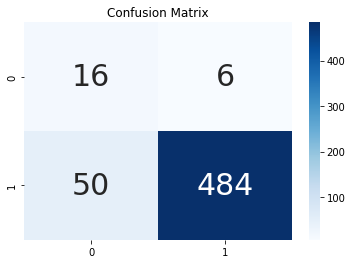

Accuracy:  0.8992805755395683
              precision    recall  f1-score   support

           0       0.24      0.73      0.36        22
           1       0.99      0.91      0.95       534

    accuracy                           0.90       556
   macro avg       0.62      0.82      0.65       556
weighted avg       0.96      0.90      0.92       556



In [41]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred)
describe_results(y_true=y_true, y_pred=y_pred, labels=list(lr_classifier.classes_))

## SVM

In [59]:
# define support vector classifier
# svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier = SVC(kernel='poly', probability=True, random_state=42)

# fit model
svm_classifier.fit(X_train_scaled, y_train)

SVC(kernel='poly', probability=True, random_state=42)

In [ ]:
print('Classes:', svm_classifier.classes_[::])
print('Coef shape:', svm_classifier.coef_.shape)
print('Coef: ', svm_classifier.coef_)

In [61]:
# Predicting the Test set results
y_pred = svm_classifier.predict(X_test)

# Predict probabilities
probs_y = svm_classifier.predict_proba(X_test)

y_score = svm_classifier.decision_function(X_test)

In [62]:
y_true = y_test
df_y_true_pred_svm = pd.DataFrame({
    'y_true': y_true, 
    'y_pred': y_pred, 
    'non_prob': probs_y[:,0], 
    'fire_prob': probs_y[:,1], 
    'y_score': y_score
})
df_y_true_pred_svm

,y_true,y_pred,non_prob,fire_prob,y_score
0,0,1,3.000001e-14,1.000000e+00,1.250293e+07
1,0,0,9.999999e-01,1.000000e-07,-1.213930e+07
2,0,0,9.999999e-01,1.000000e-07,-3.553650e+06
3,0,1,3.000001e-14,1.000000e+00,8.929961e+06
4,0,1,3.000001e-14,1.000000e+00,6.571775e+06
...,...,...,...,...,...
551,1,1,3.000001e-14,1.000000e+00,1.215605e+07
552,1,1,3.000001e-14,1.000000e+00,5.504791e+07
553,1,1,3.000001e-14,1.000000e+00,2.555466e+07
554,1,1,3.000001e-14,1.000000e+00,5.921224e+07


In [63]:
y_true=df_y_true_pred_svm['y_true']
y_pred=df_y_true_pred_svm['y_pred']

In [64]:
accuracy = accuracy_score(y_true, y_pred)
precision_recall_fscore_support_metrics = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
df_precision_recall_fscore_support_svm = pd.DataFrame(precision_recall_fscore_support_metrics,  columns=[0,1], index=['precision', 'recall', 'f1_score', 'support']).T
df_precision_recall_fscore_support_svm['accuracy'] = accuracy
df_precision_recall_fscore_support_svm['model_name'] = 'SVM'
df_precision_recall_fscore_support_svm = df_precision_recall_fscore_support_svm.reset_index().rename(columns={'index': 'label'})
df_precision_recall_fscore_support_svm

,label,precision,recall,f1_score,support,accuracy,model_name
0,0,0.416667,0.454545,0.434783,22.0,0.953237,SVM
1,1,0.977444,0.973783,0.975610,534.0,0.953237,SVM


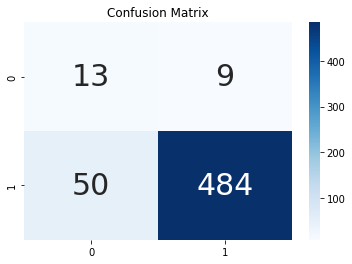

Accuracy:  0.8938848920863309
              precision    recall  f1-score   support

           0       0.21      0.59      0.31        22
           1       0.98      0.91      0.94       534

    accuracy                           0.89       556
   macro avg       0.59      0.75      0.62       556
weighted avg       0.95      0.89      0.92       556



In [48]:
# plot_confusion_matrix(y_true=y_true, y_pred=y_pred, labels=list(classifier.classes_))
plot_confusion_matrix(y_true=y_true, y_pred=y_pred)
describe_results(y_true=y_true, y_pred=y_pred, labels=list(svm_classifier.classes_)) #target_names=list(classifier.classes_))

In [68]:
models_result_data['SVM'] = {
  'df_results': df_y_true_pred_svm,
  'df_metrics': df_precision_recall_fscore_support_svm,
  'classes': list(svm_classifier.classes_)
}

## CNN

# Comparação dos modelos

In [50]:
#@title Gráficos
def plot_compare_roc_auc(data, pos_label=1):
  rows=1
  cols=1
  fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

  for model_name, attrs in data.items():
    df_results, df_metrics = attrs['df_results'], attrs['df_metrics']
    y_true = df_results['y_true']
    y_pred = df_results['y_pred']
    display = RocCurveDisplay.from_predictions(
        y_true,
        y_pred,
        pos_label=pos_label,
        name=model_name,
        linewidth=1,
        ax=axs,
    )
    axs.plot([0, 1], [0, 1], linewidth=1, linestyle=":")
    axs.set_title('ROC/AUX - (Positive label: {})'.format(pos_label))
    axs.set_xlabel("False Positive Rate")
    axs.set_ylabel("True Positive Rate")
  plt.tight_layout(pad=2.0)
  plt.show()


def plot_compare_roc_auc2(data, pos_label=1):
  rows=1
  cols=1
  fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

  for model_name, attrs in data.items():
    df_results, df_metrics = attrs['df_results'], attrs['df_metrics']
    y_true = df_results['y_true']
    y_pred = df_results['y_pred']
    y_score = df_results['y_score']
  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    roc_display = RocCurveDisplay(fpr=false_positive_rate, tpr=true_positive_rate, roc_auc=roc_auc, pos_label=pos_label, estimator_name=model_name)
  
    roc_display.plot(ax=axs)
    axs.plot([0, 1], [0, 1], linewidth=1, linestyle=":")
    axs.set_title('ROC/AUX - (Positive label: {})'.format(pos_label))
    axs.set_xlabel("False Positive Rate")
    axs.set_ylabel("True Positive Rate")
  plt.tight_layout(pad=2.0)
  plt.show()


def plot_compare_precision_recall(data, pos_label=1):
  rows=1
  cols=1
  fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

  for model_name, attrs in data.items():
    df_results, df_metrics = attrs['df_results'], attrs['df_metrics']
    y_true = df_results['y_true']
    y_pred = df_results['y_pred']
  
    display = PrecisionRecallDisplay.from_predictions(
        y_true,
        y_pred,
        pos_label=pos_label,
        name=model_name,
        linewidth=1,
        ax=axs,
    )
    axs.plot([0, 1], [0, 1], linewidth=1, linestyle=":")
    axs.set_title('Precision/Recall - (Positive label: {})'.format(pos_label))
    axs.set_xlabel("Precision")
    axs.set_ylabel("Recall")
  plt.tight_layout(pad=2.0)
  plt.show()


def plot_compare_precision_recall2(data, pos_label=1):
  rows=1
  cols=1
  fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

  for model_name, attrs in data.items():
    df_results, df_metrics = attrs['df_results'], attrs['df_metrics']
    y_true = df_results['y_true']
    y_pred = df_results['y_pred']
    y_score = df_results['y_score']
  
    precision, recall, thresholds = precision_recall_curve(y_true, y_score, pos_label=pos_label)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, pos_label=pos_label, estimator_name=model_name)

    pr_display.plot(ax=axs)
    axs.plot([0, 1], [0, 1], linewidth=1, linestyle=":")
    axs.set_title('Precision/Recall - (Positive label: {})'.format(pos_label))
    axs.set_xlabel("Precision")
    axs.set_ylabel("Recall")
  plt.tight_layout(pad=2.0)
  plt.show()

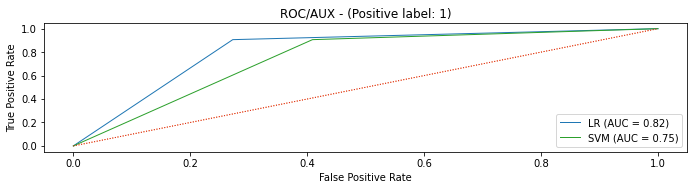

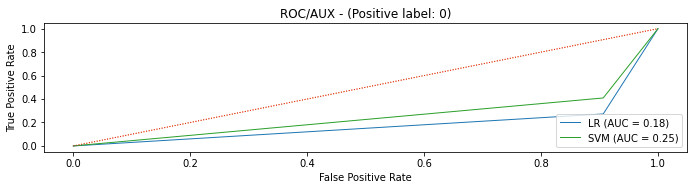

In [51]:
plot_compare_roc_auc(data=models_result_data, pos_label=1)
plot_compare_roc_auc(data=models_result_data, pos_label=0)

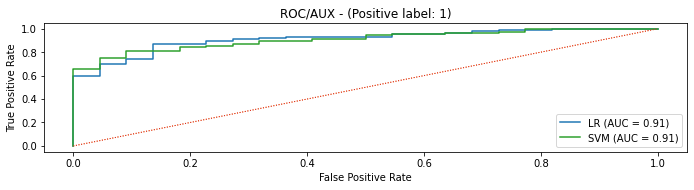

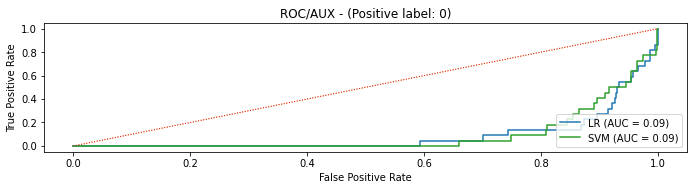

In [52]:
plot_compare_roc_auc2(data=models_result_data, pos_label=1)
plot_compare_roc_auc2(data=models_result_data, pos_label=0)

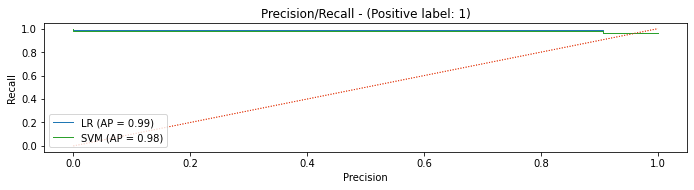

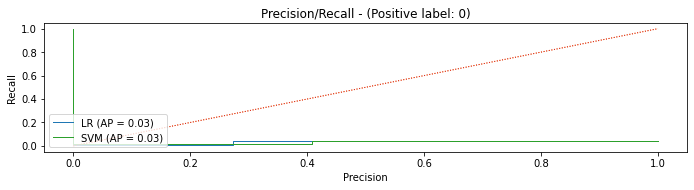

In [53]:
plot_compare_precision_recall(data=models_result_data, pos_label=1)
plot_compare_precision_recall(data=models_result_data, pos_label=0)

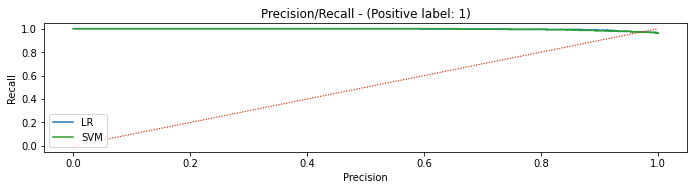

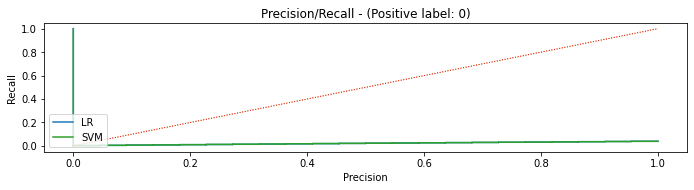

In [54]:
plot_compare_precision_recall2(data=models_result_data, pos_label=1)
plot_compare_precision_recall2(data=models_result_data, pos_label=0)

In [69]:
metrics = []
for model_name, attrs in models_result_data.items():
  metrics.append(attrs['df_metrics'])

df_metrics = pd.concat(metrics, ignore_index=True)
df_metrics

,label,precision,recall,f1_score,support,accuracy,model_name
0,0,0.242424,0.727273,0.363636,22.0,0.899281,LR
1,1,0.987755,0.906367,0.945313,534.0,0.899281,LR
2,0,0.416667,0.454545,0.434783,22.0,0.953237,SVM
3,1,0.977444,0.973783,0.975610,534.0,0.953237,SVM


In [56]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def compare_evaluation_metrics(df, positive_class):
  df = df.loc[df['label']==positive_class]
  total_models = len(df['model_name'].unique())
  fig = make_subplots(
      rows=2, cols=2,
      subplot_titles=("Accuracy", "Precision", "Recall", "F1 Score")
  )
  colors = ['blue',] * total_models


  fig.add_trace(
      go.Bar(
          x=df['model_name'], y=round(df['accuracy']*100,2), 
          text=round(df['accuracy']*100,2),
          textposition='auto',
          marker_color=colors
      ),
      row=1, col=1
  )

  fig.add_trace(
      go.Bar(
          x=df['model_name'], y=round(df['precision']*100,2),
          text=round(df['precision']*100,2),
          textposition='auto',
          marker_color=colors
      ),
      row=1, col=2
  )

  fig.add_trace(
      go.Bar(
          x=df['model_name'], y=round(df['recall']*100,2),
          text=round(df['recall']*100,2),
          textposition='auto',
          marker_color=colors
      ),
      row=2, col=1
  )

  fig.add_trace(
      go.Bar(
          x=df['model_name'], y=round(df['f1_score']*100,2),
          text=round(df['f1_score']*100,2),
          textposition='auto',
          marker_color=colors
      ),
      row=2, col=2
   )

  fig.update_layout(height=500, width=700,
                    title_text="Métricas de avaliação dos modelos (positive class - {})".format(positive_class))

  fig.update_layout(showlegend=False) 
  fig.show()




In [70]:
compare_evaluation_metrics(df=df_metrics, positive_class=1)

In [71]:
compare_evaluation_metrics(df=df_metrics, positive_class=0)